In [426]:
import os
import os.path as op
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import scipy.stats
import sklearn
import patsy
from scipy.optimize import minimize
from sklearn import linear_model
import multiprocessing
import random
# %matplotlib inline

In [427]:
#Read in data
data_dir = os.path.abspath('../')
all_rts = pd.read_csv(data_dir + '/all_rts.csv', index_col =0)
exp_order = pd.read_csv(data_dir + '/exp_order.csv', index_col =0)
exp_order = exp_order.set_index(['exp','run']).sort_index()

subjects = list(np.loadtxt(data_dir+ '/subjects.txt',str))

#some experiment variables
order_dict_ser = {'c_plus':6, 'b_plus':2, 'b_minus':3, 'c_minus':5} #coding for trial order vector
order_dict_sim = {'c_plus':4, 'b_plus':1, 'b_minus':2, 'c_minus':3}
order_dict_exp = {'ser': order_dict_ser, 'sim':order_dict_sim}

order_dict_reverse_exp = {}
for exp in ['sim','ser']:
    order_dict = order_dict_exp[exp]
    order_dict_reverse = {val:key for key,val in zip(order_dict.keys(),order_dict.values())}
    order_dict_reverse[10] = None
    if exp == 'ser':
        order_dict_reverse[1] = None
        order_dict_reverse[4] = None
    order_dict_reverse_exp[exp] = order_dict_reverse.copy()

In [428]:
### process the RTs a bit (remove trial types 1, 4, and 10 (see below) and mean center)
ser_rts = all_rts[all_rts['exp']=='ser']
ser_rts = ser_rts[ser_rts['order'] != 10] #ITI
ser_rts = ser_rts[ser_rts['order'] != 1] #A
ser_rts = ser_rts[ser_rts['order'] != 4] #A

sim_rts = all_rts[all_rts['exp']=='sim']
sim_rts = sim_rts[sim_rts['order'] != 10] #ITI

rt_dict_exp = {'ser': ser_rts, 'sim':sim_rts}

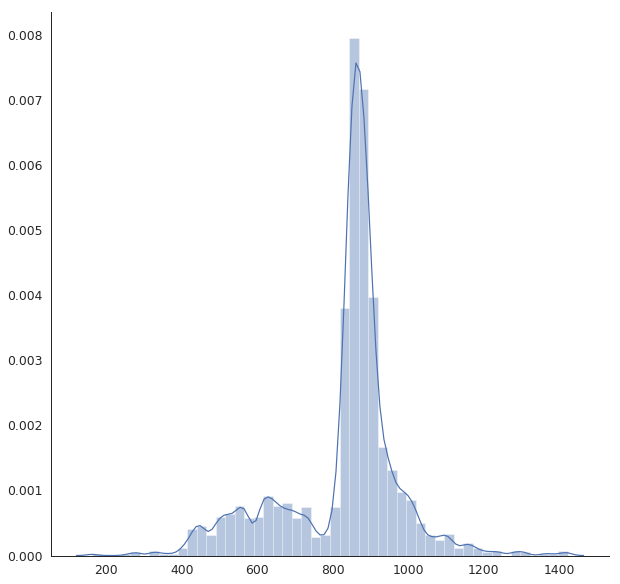

In [429]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_context('paper',font_scale = 1.4)
sns.set_style("white")

a = sim_rts.dropna()
a = a['rt'].values
a = [rt for rt in a if rt < 100000]
sns.distplot(a);
sns.despine()
# plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/RTs.png', dpi = 300)

# RL  Models

### First define some general functions that will be reused across our algorithms

In [430]:
#the same data structures are utilized across algorithms
def build_data_structures(order_dict):
    V = {x:[0] for x in order_dict.keys()}
    delta = {x:[] for x in order_dict.keys()}
    index = {x:[] for x in order_dict.keys()}
    
    return V, delta, index

In [431]:
def update_data_structures(V, delta, index, trial_type, count, PE, new_V):
    delta[trial_type].append(PE) 
    V[trial_type].append(new_V) 
    
    count += 1
    index[trial_type].append(count)
    
    return V, delta, index, count

In [432]:
def do_rl(rew_trial,trial_type,V,alpha,n):
    rew = rew_trial[n]
    PE = rew - V[trial_type][-1] #compute PE
    new_V = V[trial_type][-1] + alpha * PE #calculate V for next trial

    return new_V, PE

### Now define each RL model

In [433]:
def standard_RL(trial_order,rew_trial,alpha,exp):
    order_dict = order_dict_exp[exp]
    V, delta, index = build_data_structures(order_dict)
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:

            #perform standard RL update
            new_V, PE = do_rl(rew_trial,trial_type,V,alpha,n)
            
            #log results
            V, delta, index, count = update_data_structures(V, delta, index, trial_type, count, PE, new_V)
    return V, delta, index

In [435]:
#note index is wrong for this one. Clunky code to match data structure of other RL models
def base_rate_RL(trial_order,rew_trial,alpha,exp):
    order_dict = order_dict_exp[exp]
    V, delta, index = build_data_structures(order_dict)
    count = 0
    
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:

            #perform standard RL update
            new_V, PE = do_rl(rew_trial,trial_type,V,alpha,n)
            V, delta, index, count = update_data_structures(V, delta, index, trial_type, count, PE, new_V) 
 
            #log results
            for other_cond in order_dict_exp[exp].keys():
                if other_cond != trial_type:
                    V[other_cond].pop() #remove old V
                    V[other_cond].append(new_V) 
            
    return V, delta, index

In [436]:
#This RL algorithm keeps one state representation for each event
def feature_RL(trial_order,rew_trial,alpha,exp):    
    V = {'A':[.0], 'B' : [.0], 'C' : [.0]}
    order_dict = order_dict_exp[exp]
    V_std, delta, index = build_data_structures(order_dict)

    trial_map = {'b_plus':['A','B'], 'b_minus' : ['B'], 
                 'c_plus' : ['C'],'c_minus':['A','C']} #mapping for leak
    
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:
            rew = rew_trial[n]
            
            V_trial = 0
            for state in trial_map[trial_type]:
                V_trial += V[state][-1]
            
            #do correct RL update
            PE = rew - V_trial
            delta[trial_type].append(PE) #compute PE
            V_std[trial_type].append(V_trial)
            
            for state in trial_map[trial_type]:
                new_V = V[state][-1] + alpha * PE
                V[state].append(new_V)
 
            index[trial_type].append(count)
            count += 1
    
    return V_std, delta, index

In [437]:
def leak_RL(trial_order,rew_trial,rl_params,exp):
    
    alpha,omega = rl_params
    trial_map = {'b_plus':['b_minus','c_minus'], 'b_minus' : ['b_plus'], 
                 'c_plus' :[ 'c_minus'],'c_minus':['c_plus','b_plus']} #mapping for leak
    #set up storage structures
    order_dict = order_dict_exp[exp]
    V, delta, index = build_data_structures(order_dict)

    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:

            #perform standard RL update
            new_V, PE = do_rl(rew_trial,trial_type,V,alpha,n)
            
            #log results
            V, delta, index, count = update_data_structures(V, delta, index, trial_type, count, PE, new_V)

            #loop through other conditions and blend value update
            other_conds = [x for x in order_dict.keys() if x != trial_type]
            for other_cond in other_conds:
                if other_cond in trial_map[trial_type]: #only blend if share features
                    new_V = V[other_cond][-1] + alpha * PE * omega
                    V[other_cond].pop() #remove old V
                    V[other_cond].append(new_V) 
    return V, delta, index

In [438]:
def null_RL():
    return None

# Build dataframe for modeling

In [439]:
##function for building dataframe of relevant data for each subject
def build_df_all_bothexp(num_runs, subjects):
    alpha = .1
    exp_list = ['ser','sim']
    predictors = {'exp':[],'subject':[],'V':[],'Vbr':[],'PE':[],'run':[], 'cond':[], 'trial_index':[],'rt':[]}

    for i in range(1,num_runs+1):
        for exp in exp_list:
            order_dict = order_dict_exp[exp]
            
            ##perform RL for the experimental condition
            event_order = exp_order.loc[exp]
    
            rew = exp_order.loc[(exp,i),'rew'].values
            tt = exp_order.loc[(exp,i),'trial_order'].values
            V, delta, index = standard_RL(tt,rew,alpha,exp)
            for key in V.keys():
                V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist

            for sub in subjects:

                #get rt data for this subject and run
                rts = rt_dict_exp[exp]
                rt_data = rts[(rts['sub']==sub) & (rts['run']==i) ]

                ##update predictors dict
                for key in V.keys():
                    predictors['V'].extend(V[key])
                    predictors['Vbr'].extend(V[key])
                    predictors['PE'].extend(delta[key])
                    predictors['cond'].extend([key]*len(V[key]))
                    predictors['exp'].extend([exp]*len(V[key]))
                    predictors['subject'].extend([sub]*len(V[key]))
                    predictors['run'].extend(['run' + str(i)]*len(V[key]))
                    predictors['trial_index'].extend(index[key])
                    predictors['rt'].extend(rt_data[rt_data['order']==key]['rt'].values)
    predictors = pd.DataFrame(predictors)
    predictors = predictors.sort_values(by = ['subject','run','trial_index']) #get predictors in proper order
    predictors = predictors.set_index(['exp', 'subject','run']).sort_index()

    predictors['rt'] = np.log(predictors['rt'])
#     horrible nasty code to set response indexing. Hopfully i will find something more elegant one day
    for exp in ['sim','ser']:
        for sub in subjects:
            for run in map(str,range(1,4)):
                sub_df = predictors.loc[(exp,sub,'run' + run)]

                response = ~np.isnan(sub_df.loc[:,'rt'])
                nresponses = len(sub_df.loc[response,'trial_index'].values)
                idx = range(nresponses)
                idx = scipy.stats.zscore(idx)

                sub_df.loc[response,'resp_index'] = idx
                predictors.loc[(exp,sub,'run' + run), 'resp_index'] = sub_df.loc[(exp,sub,'run' + run),'resp_index'].values

    #add condition to the hierarchy
    predictors.set_index('cond', append=True, inplace=True)
    predictors.reset_index(level='cond').sort_index()
    predictors = z_score_dataframe(predictors,exp_list)

    return predictors

In [440]:
#Z score dataframe
def z_score_dataframe(predictors,exps):
    for sub in subjects:
        for exp in exps:
            for i in range(1,num_runs+1):
                run = 'run' + str(i)

                #mean center each run
                vals = predictors.loc[(exp,sub,run),'rt'].values
                vals = (vals - np.nanmean(vals))/np.nanstd(vals)
                predictors.loc[(exp,sub,run),'rt'] = vals

                #Z-score trial index for each row
                predictors.loc[(exp,sub,run),'trial_index'] = scipy.stats.zscore(predictors.loc[(exp,sub,run),'trial_index'])
    return predictors

# RT fitting helper functions

In [552]:
def set_params(RL_func, params):
    if RL_func.func_name == 'null_RL':        
        alpha = 0
        beta = [0]
        rl_params = alpha
        br = 0
        RL_func = standard_RL
    elif RL_func.func_name == 'leak_RL':
        alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
        omega = scipy.stats.logistic.cdf(params[1]) #blend rate, positive
        br = scipy.stats.logistic.cdf(params[2]) #leak rate
        beta = params[3:]
        rl_params = (alpha,omega)
    else:
        alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
        br = scipy.stats.logistic.cdf(params[1]) #learning rate
        beta = params[2:]
        rl_params = alpha
        
    return RL_func, rl_params, br, beta

In [705]:
##returns loss for linear regression
def regress_all(params,predictors,sub,runs,exp,RL_func,loss_quantity,epoch):
        
    ##Set up parameter specific stuff according to the RL function
    RL_func, rl_params, br, beta  = set_params(RL_func,params)
    
    ##perform RL for the experimental condition
    for run in runs:
        i = int(run[-1]) #just run number
        run_order = exp_order.loc[('sim',i)]
        rew = run_order['rew'].values
        tt = run_order['trial_order'].values
        V, delta, index = RL_func(tt,rew,rl_params,exp)
        Vbr, d, i = base_rate_RL(tt, rew, br, exp)
        
        for key in V.keys():
            idx = (run,key)
            predictors.loc[idx,'V'] = np.array(V[key][:-1])
            predictors.loc[idx,'Vbr'] = np.array(Vbr[key][:-1])

    if epoch == 'early':
        half = predictors[predictors['trial_index'] < 0]
    if epoch == 'late':
        half = predictors[predictors['trial_index'] >= 0]
       
    run_pred = predictors.loc[runs]
    #build RL matrixes
    yd,Xd = patsy.dmatrices("rt ~ V",run_pred,NA_action='drop')
    X = np.asarray(Xd)
    
    #drop intercept
    X = X[:,1:] 
    X = X - np.mean(X,0)
    y = np.array(map(float,np.asarray(yd)))
    y = y - np.mean(y)

    
    #compute prediction and loss
    y_hat = np.dot(X,beta)
    loss = np.linalg.norm(y - y_hat)
    r2 = scipy.stats.pearsonr(y_hat,y)[0]**2
    sigma = np.std(y - y_hat)

    ll = len(y) * np.log(1/(sigma *np.sqrt(2*np.pi))) - (1.0/(2*sigma**2))*(loss**2)
    ll = ll*-1
    if loss_quantity == 'r2':
        return r2
    elif loss_quantity == 'll':
        return ll

In [1]:
num_runs = 3
predictors = build_df_all_bothexp(num_runs,subjects)

In [ ]:
def run_subjects(in_tuple):
    
    sub_id, exp, rl_alg, method, params = in_tuple

    #get subject specific data
    sub_predictors = predictors.loc[exp,sub_id].copy() #deepcopy for speed
    runs = list(set(sub_predictors.index.get_level_values(0)))
    
    #minimize
    minimizer_kwargs = {"method": method, 'args':(sub_predictors,sub_id,runs,exp,
                                                    rl_alg,'ll')}
    
    res = basinhopping(regress_all, params, minimizer_kwargs=minimizer_kwargs,niter=1)

    out_df = pd.DataFrame({'LL':res.fun,
                           'alpha': scipy.stats.logistic.cdf(res.x[0]),
                           'omega': scipy.stats.logistic.cdf(res.x[1]),
                           'br': scipy.stats.logistic.cdf(res.x[2]),
                           'beta_br': res.x[-1],
                           'beta': res.x[-2],
                           'sub':sub_id,
                           'exp':exp,
                           'rl_alg':rl_alg.func_name,
                           'method':method},index = [0])
    out_f = op.abspath('../rt_fits/revision/' + '_'.join((sub_id, exp, rl_alg.func_name, method)) + '.csv')
    out_df.to_csv(out_f,index = False)

    
    return (sub_id,exp,rl_alg,method,res)

In [566]:
def minimize_func_l1so(params, predictors, subs, exp, RL_func, loss_quantity, epoch):
    
    all_ll = 0
    for sub in subs:
        sub_predictors = predictors.loc[exp,sub].copy().sort_index() #deepcopy for speed
        runs = list(set(sub_predictors.index.get_level_values(0)))
        
        ll = regress_all(params,sub_predictors,sub,runs,exp,RL_func,loss_quantity, epoch)
        if not np.isnan(ll):
            all_ll = all_ll + ll
        
    return all_ll

In [567]:
def run_subjects_l1so(in_tuple):
    sub_id, exp, rl_alg, method, params = in_tuple

    other_subs = [x for x in subjects if x != sub_id]

    
    #minimize
    minimizer_kwargs = {"method": method, 'args':(predictors,other_subs,exp,
                                                    rl_alg,'ll', None)}
    #fit
    res = basinhopping(minimize_func_l1so, params, minimizer_kwargs=minimizer_kwargs,niter=1)

    #predict
    test_LL = minimize_func_l1so(res.x, predictors, [sub_id], exp, rl_alg, 'll', None)
    print test_LL

    out_df = pd.DataFrame({'test_LL':test_LL,
                           'train_LL':res.fun,
                           'alpha': scipy.stats.logistic.cdf(res.x[0]),
                           'omega': scipy.stats.logistic.cdf(res.x[1]),
                           'br': scipy.stats.logistic.cdf(res.x[2]),
                           'beta_br': res.x[-1],
                           'beta': res.x[-2],
                           'sub':sub_id,
                           'exp':exp,
                           'rl_alg':rl_alg.func_name,
                           'method':method},index = [0])
    out_f = op.abspath('../rt_fits/revision2/l1so_br_' + '_'.join((sub_id, exp, rl_alg.func_name, method)) + '.csv')
    out_df.to_csv(out_f,index = False)


    return (sub_id,exp,rl_alg,'Success')

# run_subjects_l1so(('fd_104','sim',null_RL,'CG',[0,0,0,0]))
# minimize_func_l1so([1,2,0,0], predictors, ['fd_104'], 'sim', null_RL, 'll')

# Fit models

In [738]:
#define variables
exp = 'sim'
# from scipy.optimize import basinhopping
rl_params = {standard_RL:[0,0,0],
             leak_RL:[0,0,0,0],
            feature_RL:[0,0,0],
            base_rate_RL:[0,0,0]}


in_tuples = []
method = ['CG']

bad_subs = ['fd_122']
good_subs = [x for x in subjects if x not in bad_subs]
for sub in good_subs:
    for alg, params in rl_params.iteritems():
        for meth in method:
            in_tuples.append((sub, exp, alg ,meth,params))
subjects = good_subs

In [739]:
# pool = multiprocessing.Pool()
# res = pool.map(run_subjects_l1so,in_tuples)
# pool.terminate()
# pool.join()

# Analyze results

In [740]:
results = []
for tup in in_tuples:
    sub_id, exp, rl_alg, method, params = tup
    #get subject specific data
    sub_predictors = predictors.loc[exp,sub_id].copy() #deepcopy for speed
    runs = list(set(sub_predictors.index.get_level_values(0)))
    out_f = op.abspath('../rt_fits/l1so' + '_'.join((sub_id, exp, rl_alg.func_name, method)) + '.csv')
    in_df = pd.read_csv(out_f)
    in_df['sub'] = sub_id
    results.append(in_df)
    
    if rl_alg.func_name == 'leak_RL':
        out_f = op.abspath('../rt_fits/l1so' + '_'.join((sub_id, exp, rl_alg.func_name, method)) + '.csv')
        in_df = pd.read_csv(out_f)
        in_df['rl_alg'] = 'leak_br'
        in_df['sub'] = sub_id
        results.append(in_df)

results = pd.concat(results)
results = results[results['sub'] != 'fd_122']

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [741]:
results = results.set_index(['sub','rl_alg'])
for row in set(results.index):
    sub, alg = row
    sub_predictors = predictors.loc[exp,sub].dropna()
    nchoices = sub_predictors.shape[0]
    results.loc[row,'ll_per_choice'] = results.loc[row,'test_LL'] * 1.0/nchoices


In [664]:
print results.groupby('rl_alg').median()
scipy.stats.wilcoxon(results.loc[results['rl_alg'] == 'leak_RL','beta_br'].values)

             level_0  index         LL     alpha      beta   beta_br  \
rl_alg                                                                 
feature_RL        47      0  82.128981  0.336992 -0.141241 -0.497694   
leak_RL           46      0  76.591958  0.413907  0.000000 -1.441464   
standard_RL       45      0  77.780347  0.488514  0.000000 -0.781608   

                   br     omega  
rl_alg                           
feature_RL   0.464748  0.502537  
leak_RL      0.464748  0.580675  
standard_RL  0.500000  0.500000  


WilcoxonResult(statistic=81.0, pvalue=0.001065544905170351)

Text(0,0.5,'Predictive Likelihood\nPer Trial')

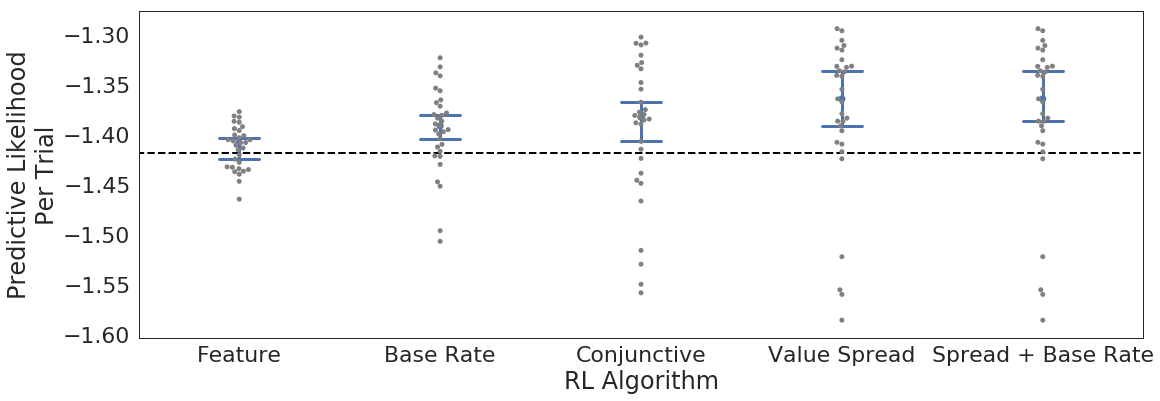

In [748]:
# results = results.reset_index()
r = results.loc[results['rl_alg'] != 'null_RL']
alg_map = {'standard_RL':'Conjunctive', 'null_RL':'No Learning','leak_RL':'Value Spread','base_rate_RL':'Base Rate',
           'single_item_state':'Feature','feature_RL':'Feature' ,'hybrid_RL':'Two Systems', 'leak_br':'Spread + Base Rate'}
r['RL Algorithm'] = [alg_map[x] for x in r['rl_alg']]
r['ll_per_choice'] = r['ll_per_choice']*-1
sns.set_style("white")
sns.set_context('paper',font_scale = 2.5)
plt.figure(figsize=(18,6))

sns.swarmplot(x = 'RL Algorithm', 
              y = 'll_per_choice',
              dodge = .5,
              color = 'gray',
              order = ['Feature','Base Rate','Conjunctive','Value Spread','Spread + Base Rate'],
              data = r)
ax = sns.pointplot(x = 'RL Algorithm', 
              y = 'll_per_choice', 
            order = ['Feature','Base Rate','Conjunctive','Value Spread', 'Spread + Base Rate'],
                   estimator= np.median,
               capsize=.2,
                 errwidth=3,
              join = False,
              data = r)
plt.plot(np.linspace(-20,120,1000), [null_ll]*1000, linestyle = 'dashed', color = 'black', linewidth = 2)

plt.ylabel('Predictive Likelihood\nPer Trial')
# sns.despine()
# plt.savefig('/home/iballard/Dropbox/fd/figs/revision2/model_comparison.png', 
#             dpi = 300,
#            bbox_inches = 'tight')

In [623]:
r = results.set_index(['rl_alg','sub'])
diff = r.loc['leak_RL']['ll_per_choice'] - r.loc['standard_RL']['ll_per_choice']
print 'leak - standard', scipy.stats.wilcoxon(diff.values)

diff = r.loc['standard_RL']['ll_per_choice'] - r.loc['null_RL']['ll_per_choice']
print 'standard - null', scipy.stats.wilcoxon(diff.values)

diff = r.loc['single_item_state']['ll_per_choice'] - r.loc['null_RL']['ll_per_choice']
print 'feature - null', scipy.stats.wilcoxon(diff.values)

diff = r.loc['standard_RL']['ll_per_choice'] - r.loc['single_item_state']['ll_per_choice']
print 'standard - feature', scipy.stats.wilcoxon(diff.values)

diff = r.loc['leak_RL']['ll_per_choice'] - r.loc['single_item_state']['ll_per_choice']
print 'leak - feature', scipy.stats.wilcoxon(diff.values)

leak - standard WilcoxonResult(statistic=127.0, pvalue=0.017731299870946442)
standard - null WilcoxonResult(statistic=147.0, pvalue=0.0477877479213932)
feature - null WilcoxonResult(statistic=183.0, pvalue=0.20274301595257616)
standard - feature WilcoxonResult(statistic=166.0, pvalue=0.10807264392253305)
leak - feature WilcoxonResult(statistic=117.0, pvalue=0.010253901433485788)


In [335]:
import statsmodels.formula.api as smf
ll = rs[rs['alg'] != 'leak_RL']

model_str = 'll ~ C(epoch)*alg'
mixedfx = smf.mixedlm(model_str, ll, groups = ll['sub'])

mixedfx = mixedfx.fit()
print mixedfx.summary()

                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          ll       
No. Observations:          124              Method:                      REML     
No. Groups:                31               Scale:                       25.8187  
Min. group size:           4                Likelihood:                  -392.1736
Max. group size:           4                Converged:                   Yes      
Mean group size:           4.0                                                    
----------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                           -40.816    1.189 -34.339 0.000 -43.146 -38.487
C(epoch)[T.late]                      6.025    1.291   4.668 0.000   3.495   8.555
alg[T.standard_RL]        

# Compute per run likelihood of fitted models

In [712]:
rs = []
for sub in set(results['sub']):
    RL_func = leak_RL

    subject_df = results[results['sub'] == sub]
    
    for alg in [ leak_RL]:#standard_RL, feature_RL,
        if alg != null_RL:
            subr = subject_df[subject_df['rl_alg'] == alg.func_name]
            params = (scipy.stats.logistic.ppf(subr['alpha'].values[0]),
                      scipy.stats.logistic.ppf(subr['omega'].values[0]),
                      subr['br'].values[0],
#                       subr['beta'].values[0],
                      subr['beta_br'].values[0])
        else:
            params = [0,0,0]

        sub_predictors = predictors.loc[exp,sub].copy().sort_index() #deepcopy for speed
        runs = list(set(sub_predictors.index.get_level_values(0)))

        for r in runs:
            ll = regress_all(params,sub_predictors,sub,[r],exp,alg,'ll',None)

            rs.append(pd.DataFrame({'ll':ll*-1,
                                   'run':r,
                                    'alg':alg.func_name,
                                   'sub':sub}, 
                                   index = [0]))
rs = pd.concat(rs)

In [714]:
rs = rs.set_index(['sub','run','alg'])
for row in set(rs.index):
    sub, run, alg = row
    sub_predictors = predictors.loc[exp,sub,run].dropna()
    nchoices = sub_predictors.shape[0]
    rs.loc[row,'ll_per_choice'] = rs.loc[row,'ll'] * 1.0/nchoices
rs = rs.reset_index()

Text(0,0.5,'Log Likelihood')

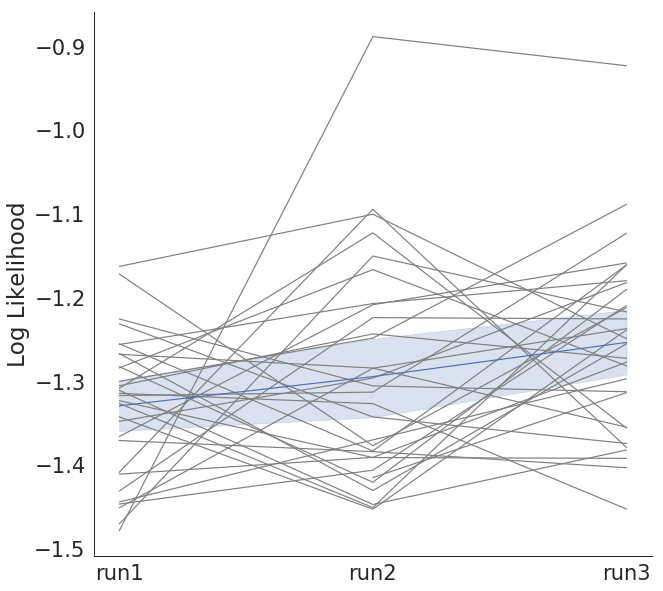

In [715]:
fig_df = rs[rs['alg'] == 'leak_RL']
sns.set_context('paper',font_scale = 2.4)
ax = sns.lineplot(x = 'run', 
             y = 'll_per_choice',
             data = fig_df, 
             units = 'sub',
             color = 'grey',
             estimator=None)
sns.lineplot(x = 'run', 
             y = 'll_per_choice',
             data = fig_df, 
                 ax = ax)
sns.despine()
plt.xlabel('')
plt.ylabel('Log Likelihood')
# plt.savefig('/home/iballard/Dropbox/fd/figs/revision/run_analysis.png', 
#             dpi = 300,
#            bbox_inches = 'tight')

In [717]:
fig_df.to_csv('/home/iballard/Dropbox/fd/paper/data/run_fits.csv',index = False)

In [368]:
import statsmodels.formula.api as smf
fig_df['run_idx'] = [int(x[-1]) for x in fig_df['run']]
fig_df = fig_df.dropna()
model_str = 'll_per_choice ~ run_idx'
mixedfx = smf.mixedlm(model_str, fig_df, groups = fig_df['sub'])
mixedfx.fit().summary()

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: ll_per_choice
No. Observations: 92      Method:             REML         
No. Groups:       31      Scale:              0.0117       
Min. group size:  2       Likelihood:         66.6973      
Max. group size:  3       Converged:          Yes          
Mean group size:  3.0                                      
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -1.368     0.030  -45.159  0.000  -1.428  -1.309
run_idx      0.038     0.014    2.738  0.006   0.011   0.065
groups RE    0.000     0.013                                
===========================================================

"""

In [404]:
#save fit differences for brain-behavior analyses
df = rs.sort_values(by = ['alg','sub','run']).set_index(['alg','run'])

res = []
for run in ['run1','run2','run3']:
    diff_conj = df.loc[('leak_RL',run),'ll'].values - df.loc[('standard_RL',run),'ll'].values
    diff_null = df.loc[('leak_RL',run),'ll'].values - df.loc[('null_RL',run),'ll'].values
    
    res.append(pd.DataFrame({'diff_conj':diff_conj,
                             'diff_null':diff_null,
                             'run':[run]*len(diff),
                             'sub':df.loc[('standard_RL',run),'sub'].values}))
res = pd.concat(res)

# Simulate RL data for Figure 2

In [ ]:
def simulate_RL(RL_func,rl_params):
    if isinstance(rl_params,float):
        alpha = rl_params
    else:
        alpha,d = rl_params

    exp = 'sim'
    all_V =[]
    ##perform RL for the experimental condition
    for i in range(1,num_runs+1):
        run_order = exp_order.loc[('sim',i)]
        rew = run_order['rew'].values
        tt = run_order['trial_order'].values

        V, delta, index = RL_func(tt,rew,rl_params,exp,i,'sub')
        V = pd.DataFrame(V)
        delta = pd.DataFrame(delta)
        V['trial'] = range(1,V.shape[0]+1)
        V = V[V['trial']<=10]
        delta['trial'] = range(delta.shape[0])
        V = pd.melt(V,
            id_vars=["trial"],
            value_vars=["b_minus", "b_plus",'c_minus','c_plus'],
            value_name="V")
        delta = pd.melt(delta,
            id_vars=["trial"],
            value_vars=["b_minus", "b_plus",'c_minus','c_plus'],
            value_name="PE")
        V['PE'] = delta['PE']
        V['run'] = i
        all_V.append(V.copy())
    V = pd.concat(all_V)
    
    V['variable'] = [stim_map[x] for x in V['variable']]
    V['Stimulus'] = V['variable']
    return V

In [ ]:
palette = ["#A5C8B3","#A5C8B3", "#A1B6C6","#A1B6C6"]
sns.palplot(sns.color_palette(palette))
plot_order = ['AB+','C+','AC-','B-']
sns.set_context('paper',font_scale = 2)
sns.set_style("white")
stim_map = {'b_plus':'AB+','b_minus':'B-','c_plus':'C+','c_minus':'AC-'}

In [ ]:
V = simulate_RL(leak_RL, (.38,.41))
V = V.groupby('Stimulus').mean().reset_index()
# V['V'] = V['V']*-1
sns.barplot(x = 'Stimulus', 
            y = 'V', 
            palette = palette,
            order = plot_order,
            data = V)
sns.despine()
plt.ylabel('Value Spread\nValue')
plt.savefig('../figs/revision/ValueSpread.png',dpi = 300,bbox_inches = 'tight')

In [ ]:
V = simulate_RL(leak_RL, (.38,.41))
V = V.groupby('Stimulus').mean().reset_index()
# V['V'] = V['V']*-1
sns.barplot(x = 'Stimulus', 
            y = 'V', 
            palette = palette,
            order = plot_order,
            data = V)
sns.despine()
plt.ylabel('Value Spread\nValue')
plt.savefig('../figs/revision/ValueSpread.png',dpi = 300,bbox_inches = 'tight')

In [ ]:
V = simulate_RL(standard_RL, (.38))
sns.set_context('paper',font_scale = 2.5)
V = V.groupby('Stimulus').mean().reset_index()
sns.barplot(x = 'Stimulus', 
            y = 'V', 
            palette = palette,
            order = plot_order,
            data = V)
plt.ylabel('Conjunctive Model\nValue')
sns.despine()
plt.savefig('../figs/revision/ConjunctiveRL.png',dpi = 300, bbox_inches = 'tight')

In [ ]:
V = simulate_RL(single_item_state, .38)
V = V.groupby('Stimulus').mean().reset_index()
sns.barplot(x = 'Stimulus', 
            y = 'V', 
            palette = palette,
            order = plot_order,
            data = V)
plt.ylabel('Feature Model\nValue')
sns.despine()
plt.savefig('../figs/revision/featureRL.png',dpi = 300, bbox_inches = 'tight')